# $\delta_{\phi_P}(\alpha_Q, N_{\mathrm{LF}}) \equiv \langle \phi_P^{\mathrm{(obs)}}\rangle - \langle{\phi_{P}^{\mathrm{(exp)}}}\rangle \neq 0$ 

In [1]:
import sys
import os
import pickle

import numpy as np

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%autoreload 2

In [3]:
from utils.data_loader import DataLoader
dataloader = DataLoader()

In [4]:
import matplotlib as mpl

In [5]:
mpl.rc_params = mpl.rcParamsDefault

* Define `root_log_dir`, containing multiple `model_dirs`: 
    ```
    model_dirs = list_and_join(root_log_dir) 
               = ['root_log_dir/model_dir1/', 'root_log_dir/model_dir2/', ...]
    ```
* For each `log_dir` in `model_dirs`, find all the run directories it contains: 
    ```
    log_dirs = list_and_join(model_dirs) 
             = ['root_log_dir/log_dir1/run_1/', 'root_log_dir/log_dir2/run_1/', ...]
    ```
* Then, for each `log_dir` in `log_dirs` find and create a list of each `run_dir` in:
    ```
    runs_dirs = [os.path.join(d, 'runs') for d in log_dirs if 'lattice' in d]
    ```
    i.e.
    ```
    run_dirs = [list_and_join(d) for d in runs_dirs]
             = [['root_log_dir/log_dir1/run_1/runs/steps100_beta2.0_eps0.1`,
                 'root_log_dir/log_dir1/run_1/runs/steps100_beta3.0_eps0.1`, ...],
                ['root_log_dir/log_dir2/run_1/runs/steps100_beta2.0_eps0.1`,
                 'root_log_dir/log_dir2/run_1/runs/steps100_beta3.0_eps0.1`, ...], ...]
    ```

In [171]:
from utils.file_io import list_and_join

rld = '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7'
root_log_dir = os.path.join(*rld.split('/'))
model_dirs = list_and_join(root_log_dir)
log_dirs = list_and_join(model_dirs)
runs_dirs = [os.path.join(d, 'runs') for d in log_dirs if 'lattice' in d]
# run_dirs is a list of lists, where each entry in run_dirs is a list
# of all the run directories for that individual log_dir.
# e.g. log_dirs = ['root_log_dir/log_dir1/run_1/',
#                  'root_log_dir/log_dir2/run_1/', ...]
# then:
#     runs_dirs = ['root_log_dir/log_dir1/run_1/runs/',
#                  'root_log_dir/log_dir2/run_1/runs/', ...]
# then 
#     run_dirs = [
#         ['root_log_dir/log_dir1/run_1/runs/steps100_beta2.0_eps0.1`,
#          'root_log_dir/log_dir1/run_1/runs/steps100_beta3.0_eps0.1`, ...],
#         ['root_log_dir/log_dir2/run_1/runs/steps100_beta2.0_eps0.1`,
#          'root_log_dir/log_dir2/run_1/runs/steps100_beta3.0_eps0.1`, ...],
#         ...
#     ]
run_dirs = [list_and_join(d) for d in runs_dirs]
run_dirs

[['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs/steps_20000_beta_6.0_eps_0.1',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs/steps_20000_beta_5.0_eps_0.1',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs/steps_20000_beta_4.0_eps_0.1'],
 ['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/HMC_lattice8_batch256_lf7_eps0.2/run_1/runs/steps_10000_beta_6.0_eps_0.2',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/HMC_lattice8_batch256_lf7_eps0.2/run_1/runs/steps_10000_beta_5.0_eps_0.2'],
 ['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.0/run_1/runs/steps_20000_beta_6.0_eps_0.1',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.0/run_1/runs/steps_20000_beta_5.0_eps_0.1',
  '../../log

Separate `L2HMC` dirs from `HMC` dirs:

In [172]:
l2hmc_run_dirs = []
hmc_run_dirs = []
for d in run_dirs:
    if 'HMC' in d[0]:
        hmc_run_dirs.append(d)
    else:
        l2hmc_run_dirs.append(d)
l2hmc_run_dirs; hmc_run_dirs

[['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs/steps_20000_beta_6.0_eps_0.1',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs/steps_20000_beta_5.0_eps_0.1',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs/steps_20000_beta_4.0_eps_0.1'],
 ['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.0/run_1/runs/steps_20000_beta_6.0_eps_0.1',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.0/run_1/runs/steps_20000_beta_5.0_eps_0.1',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.0/run_1/runs/steps_20000_beta_4.0_eps_0.1'],
 ['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw1.0/run_1/runs/steps_20000_beta_6.0_eps_0.1',
  '../..

[['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/HMC_lattice8_batch256_lf7_eps0.2/run_1/runs/steps_10000_beta_6.0_eps_0.2',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/HMC_lattice8_batch256_lf7_eps0.2/run_1/runs/steps_10000_beta_5.0_eps_0.2'],
 ['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/HMC_lattice8_batch256_lf7_eps0.219/run_1/runs/steps_20000_beta_5.0_eps_0.219',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/HMC_lattice8_batch256_lf7_eps0.219/run_1/runs/steps_20000_beta_4.0_eps_0.219'],
 ['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/HMC_lattice8_batch256_lf7_eps0.15/run_1/runs/steps_10000_beta_5.0_eps_0.15',
  '../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/HMC_lattice8_batch256_lf7_eps0.15/run_1/runs/steps_10000_beta_6.0_eps_0.15'],
 ['../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/HMC_lattice8_batch256_lf7_eps0.1/run_1/runs/steps_10000_beta_5.0_eps_0.1',
  '../../log

Define a helper method `load_runs_info` to load relevant information from all directories in `run_dirs`:

In [173]:
import pickle
from utils.file_io import get_eps_from_run_history_txt_file
from utils.data_loader import DataLoader

def get_arr(x):
    if isinstance(x, dict):
        return np.array(list(x.values()))
    return np.array(x)
    

def load_runs_info(run_dirs):
    """Create dict. containing info about each dir in run_dirs.
    
    Args:
        run_dirs: List of lists containing paths to individual run directories.
        
    Returns:
        runs_info: Dict. with `run_data` and other 
            relevant information for each dir in run_dirs.
    """
    data_loader = DataLoader()
    runs_info = {}
    for i in run_dirs:
        parent_dir = os.path.dirname(i[0])
        key = parent_dir.split('/')[-3]
        print(f'Parent dir: {parent_dir}')
        existing = key in list(runs_info.keys())
        if key in list(runs_info.keys()):
            key += '_1'
            if key in list(runs_info.keys()):
                num = int(key[-1]) + int(1)
                key = key.rstrip(str(num - 1)) + str(num)
        runs_info[key] = {}
        print(f'  key: {key}')
        log_dir = os.path.dirname(parent_dir)
        runs_info[key]['log_dir'] = log_dir
        runs_info[key]['runs_data'] = {}
        for p in i:
            print(f'  Loading run_data from: {p}')
            rh_txt_file = os.path.join(p, 'run_history.txt')
            if os.path.isfile(rh_txt_file):
                eps = get_eps_from_run_history_txt_file(rh_txt_file)
            run_data_file = os.path.join(p, 'run_data.pkl')
            if os.path.isfile(run_data_file):
                params = data_loader.load_params(p)
                params['eps'] = eps
                plaqs =  get_arr(data_loader.load_plaqs(p))
                #data_loader.load_observable('plaqs', p)
                charges_autocorrs = get_arr(data_loader.load_autocorrs(p))
                #data_loader.load_observable('charges_autocorrs', p)
                run_data = data_loader.load_run_data(p)
                p_split = p.split('_')
                beta = float(p_split[-3])
                runs_info[key]['runs_data'][beta] = {
                    'params': params,
                    'run_data': run_data,
                    'run_dir': p,
                    'eps': eps,
                    'charges_autocorrs': charges_autocorrs,
                    'plaqs': plaqs,
                    #'plaqs': plaqs,
                    #'charges_autocorrs': charges_autocorrs
                }
        
    return runs_info

In [176]:
params = []
def get_model_params(runs_info):
    for key, val in runs_info.items():
        split_key = key.split('_')
        L = int(split_key[0].lstrip('lattice'))
        batch_size = int(split_key[1].lstrip('batch'))
        lf = int(split_key[2].lstrip('lf'))
        params.append((L, batch_size, lf))
    return params 

model_params = get_model_params(l2hmc_runs_info)
model_params

[(8, 256, 7), (8, 256, 7), (8, 256, 7), (8, 256, 7)]

In [177]:
l2hmc_runs_info = load_runs_info(l2hmc_run_dirs)
hmc_runs_info = load_runs_info(hmc_run_dirs)

Parent dir: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs
  key: lattice8_batch256_lf7_eps0.1_qw0.25
  Loading run_data from: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs/steps_20000_beta_6.0_eps_0.1
  Loading run_data from: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs/steps_20000_beta_5.0_eps_0.1
  Loading run_data from: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.25/run_1/runs/steps_20000_beta_4.0_eps_0.1
Parent dir: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.0/run_1/runs
  key: lattice8_batch256_lf7_eps0.1_qw0.0
  Loading run_data from: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/lattice8_batch256_lf7_eps0.1_qw0.0/run_1/runs/steps_20000_beta_6.0_eps_0.1
  Loading run_data from: ../.

In [178]:
def extract_observable(runs_info, obs_key):
    """Extract observable from `run_data['obs_key']`."""
    observable = {}
    eps_dict = {}
    for k1, v1 in runs_info.items():
        print(f'k1: {k1}')
        data = v1['runs_data']
        #run_type = 'HMC' if 'HMC' in k1 else 'L2HMC'
        for k2, v2 in data.items():
            beta = k2
            eps = v2['eps']
            charge_weight = v2['params']['charge_weight']
            num_steps = v2['params']['num_steps']
            num_samples = v2['params']['num_samples']
            size = v2['params']['space_size']
            if 'HMC' in k1:
                key = (beta, eps)
            else:
                key = (charge_weight, beta)
            eps_dict[key] = eps
            #print(f'{beta}, {eps:.4g}, {charge_weight}')
            print(f'  key: {key}')
            try:
                data = np.array(v2[obs_key])
            except KeyError:
                print(f"Unable to extract {obs_key} from data.")
                if obs_key in v2['run_data'].keys():
                    data = np.array(v2['run_data'][obs_key])
                else:
                    print(f"Unable to extract {obs_key} from `runs_info`.")
                    continue
            #try:
            #    observable[key].append(data)
            #except:
            observable[key] = data
                  
    return observable, eps_dict

## Look at the difference between observed and expected value of the average plaquette: $$\delta_{\phi_P}(\alpha_Q, N_{\mathrm{LF}}) \equiv \langle \phi_P^{\mathrm{(obs)}}\rangle - \langle{\phi_{P}^{\mathrm{(exp)}}}\rangle \neq 0$$

In [179]:
l2hmc_plaqs, l2hmc_eps_dict = extract_observable(l2hmc_runs_info, 'plaqs')
hmc_plaqs, hmc_eps_dict = extract_observable(hmc_runs_info, 'plaqs')

k1: lattice8_batch256_lf7_eps0.1_qw0.25
  key: (0.25, 6.0)
  key: (0.25, 5.0)
  key: (0.25, 4.0)
k1: lattice8_batch256_lf7_eps0.1_qw0.0
  key: (0.0, 5.0)
  key: (0.0, 4.0)
k1: lattice8_batch256_lf7_eps0.1_qw1.0
  key: (1.0, 6.0)
  key: (1.0, 5.0)
  key: (1.0, 4.0)
k1: lattice8_batch256_lf7_eps0.1_qw0.5
  key: (0.5, 6.0)
  key: (0.5, 5.0)
  key: (0.5, 4.0)
k1: HMC_lattice8_batch256_lf7_eps0.2
  key: (6.0, 0.2)
  key: (5.0, 0.2)
k1: HMC_lattice8_batch256_lf7_eps0.219
  key: (4.0, 0.2185)
k1: HMC_lattice8_batch256_lf7_eps0.15
  key: (5.0, 0.15)
  key: (6.0, 0.15)
k1: HMC_lattice8_batch256_lf7_eps0.1
  key: (5.0, 0.1)
  key: (6.0, 0.1)
k1: HMC_lattice8_batch256_lf7_eps0.218
  key: (4.0, 0.2182)
k1: HMC_lattice8_batch256_lf7_eps0.25
  key: (5.0, 0.25)
  key: (6.0, 0.25)
k1: HMC_lattice8_batch256_lf7_eps0.175
  key: (5.0, 0.175)
  key: (6.0, 0.175)


In [180]:
from lattice.lattice import u1_plaq_exact
beta_unique = np.unique(np.array(list(l2hmc_plaqs.keys()))[:, 1])

plaqs_exact = {k: v for (k, v) in zip(beta_unique, u1_plaq_exact(beta_unique))}
plaqs_exact

{4.0: 0.8635226110245504, 5.0: 0.8933831370440852, 6.0: 0.9123593043529149}

In [181]:
from scipy.stats import sem

def get_mean_err(x, therm_frac=10):
    num_steps = x.shape[0]
    therm_steps = int(num_steps // therm_frac)
    x = x[therm_steps:, :]
    avg = np.mean(x, axis=0)
    err = sem(x)
    return avg, err

In [182]:
 def get_plaq_diffs_stats(plaqs, hmc=False):
    if hmc:
        idx = 0
    else:
        idx = 1
    plaq_diffs = {
        k: np.abs(v - u1_plaq_exact(k[idx])) for (k, v) in plaqs.items()
    }
    plaq_stats = {
        k: get_mean_err(v) for (k, v) in plaq_diffs.items()
    }
    return plaq_diffs, plaq_stats

In [183]:
l2hmc_plaq_diffs, l2hmc_plaq_stats = get_plaq_diffs_stats(l2hmc_plaqs)
hmc_plaq_diffs, hmc_plaq_stats = get_plaq_diffs_stats(hmc_plaqs, hmc=True)

In [187]:
%matplotlib notebook

import matplotlib.pyplot as plt
import utils.file_io as io

mpl.rcdefaults()

def plot_plaq_diffs(plaq_diffs, eps_dict, hmc=False, skips=100, xi=100):
    out_dir = os.path.join(root_log_dir, 'plaq_diffs_plots')
    eps_dir = os.path.join(out_dir, 'eps_plots')
    io.check_else_make_dir(out_dir)
    io.check_else_make_dir(eps_dir)
    if hmc:
        betas = np.unique(np.array(list(plaq_diffs.keys()))[:, 0])
        keys1 = np.unique(np.array(list(plaq_diffs.keys()))[:, 1])
    else:
        betas = np.unique(np.array(list(plaq_diffs.keys()))[:, 1])
        keys1 = np.unique(np.array(list(plaq_diffs.keys()))[:, 0])
    for beta in betas:
        fig, ax = plt.subplots()
        #for charge_weight in charge_weights:
        for key1 in keys1:
            if hmc:
                eps = key1
                key = (beta, eps)
                if eps == 0.3:
                    continue
            else:
                charge_weight = key1
                key = (charge_weight, beta)
                try:
                    eps = eps_dict[key]
                except KeyError:
                    continue
                
            eps_label = r'$\varepsilon=$' + f'{eps:.4g}'
            try:
                diff = plaq_diffs[key][xi:][::skips]
            except KeyError:
                continue
            #diff = plaq_diffs[beta][charge_weight][xi:][::skips]
            steps = xi + skips * np.arange(len(diff))
            if hmc:
                label = eps_label
            else:
                label = (r'$\alpha_{\mathrm{Q}}=$' + f'{charge_weight}, '
                         + eps_label)
            _ = ax.plot(steps, np.mean(diff, axis=1), 
                        label=label, alpha=0.9)
            #except KeyError:
            #    continue
        labels = [i for i in np.arange(0, steps[-1] + 1000, 2000)]
        str_labels = [str(i) for i in labels]
        labels[0] = xi
        str_labels[0] = str(xi)
        _ = plt.xticks(labels, str_labels)
        _ = ax.set_xlabel('MD Step', fontsize=14)
        _ = ax.set_xlim((50, 10000))
        _ = ax.set_ylabel(r'$\delta_{\mathrm{plaq}}$', fontsize=14)
        L, batch_size, lf = model_params[0]
        title_str = (r'$L=$' + f'{L}, ' 
                     + r'$N_{\mathrm{samples}}=$' + f'{batch_size}, '
                     + r'$N_{\mathrm{LF}}=$' + f'{lf}, '
                     + r'$\beta=$' + f'{beta}')
        _ = ax.set_title(title_str, fontsize=16)
        _ = ax.legend(loc='best')
        _ = fig.tight_layout()
        filename = f'plaq_diff_beta{beta}'
        if hmc:
            filename += '_HMC'
        out_file1 = os.path.join(out_dir, filename + '.png')
        out_file2 = os.path.join(eps_dir, filename + '.eps')
        print(f'Saving figure to: {out_file1}')
        _ = plt.savefig(out_file1, dpi=400, bbox_inches='tight')
        print(f'Saving figure to: {out_file2}')
        _ = plt.savefig(out_file2, dpi=400, bbox_inches='tight')
        plt.show()

<IPython.core.display.Javascript object>


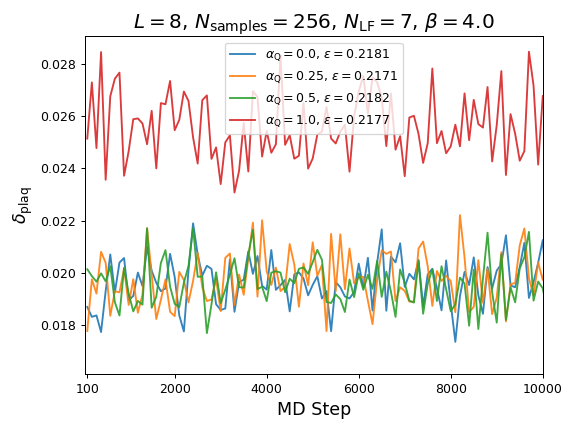

Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/plaq_diff_beta4.0.png
Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/eps_plots/plaq_diff_beta4.0.eps


<IPython.core.display.Javascript object>


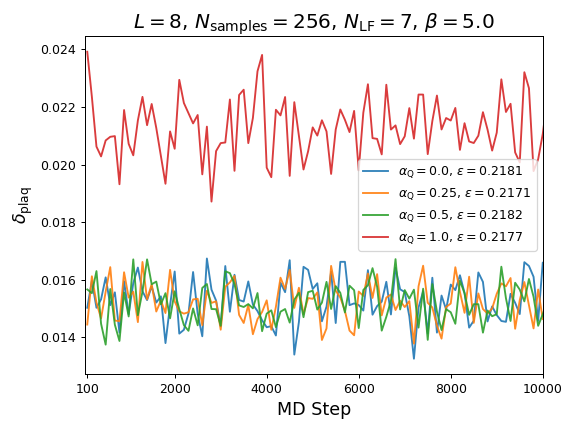

Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/plaq_diff_beta5.0.png
Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/eps_plots/plaq_diff_beta5.0.eps


<IPython.core.display.Javascript object>


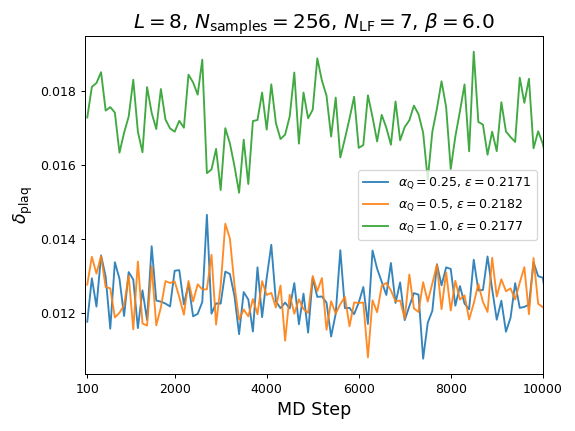

Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/plaq_diff_beta6.0.png
Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/eps_plots/plaq_diff_beta6.0.eps


In [185]:
plot_plaq_diffs(l2hmc_plaq_diffs, l2hmc_eps_dict, skips=100, xi=100)

<IPython.core.display.Javascript object>


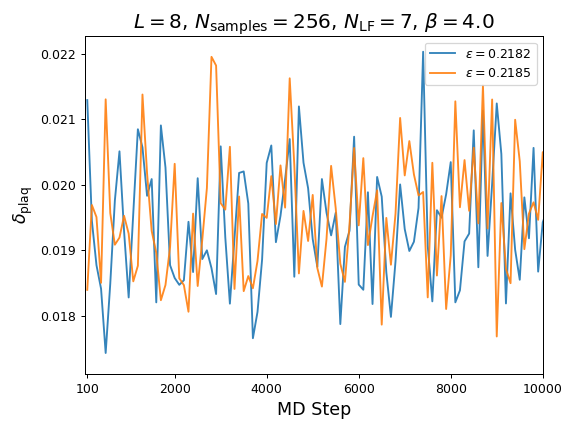

Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/plaq_diff_beta4.0_HMC.png
Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/eps_plots/plaq_diff_beta4.0_HMC.eps


<IPython.core.display.Javascript object>


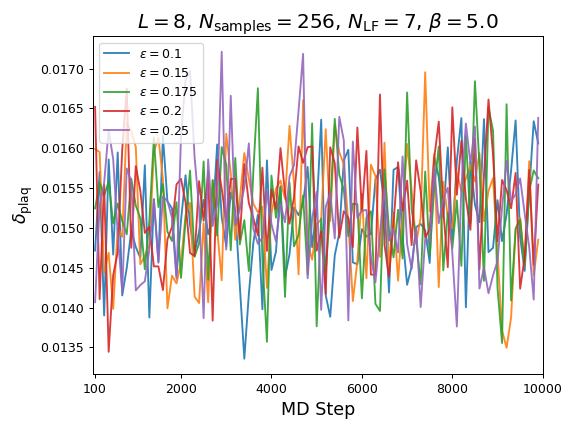

Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/plaq_diff_beta5.0_HMC.png
Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/eps_plots/plaq_diff_beta5.0_HMC.eps


<IPython.core.display.Javascript object>


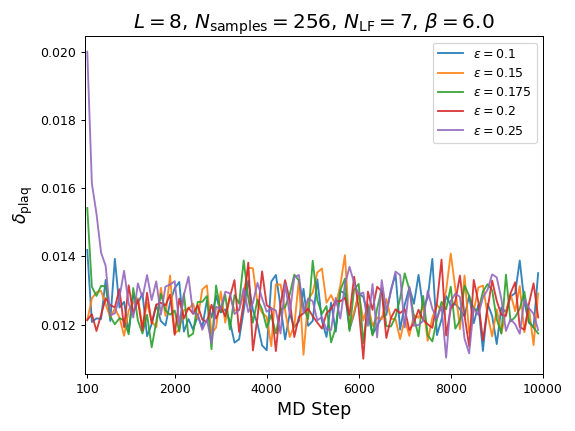

Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/plaq_diff_beta6.0_HMC.png
Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/plaq_diffs_plots/eps_plots/plaq_diff_beta6.0_HMC.eps


In [188]:
plot_plaq_diffs(hmc_plaq_diffs, hmc_eps_dict, hmc=True, skips=100, xi=100)

## Look at the autocorrelation of the topological charge $Q$

In [189]:
def get_autocorrs_stats(autocorrs):
    stats = {
        k: get_mean_err(v) for (k, v) in autocorrs.items()
    }
    
    return stats

In [190]:
l2hmc_autocorrs, l2hmc_eps_dict = extract_observable(l2hmc_runs_info,
                                                     'charges_autocorrs')

hmc_autocorrs, hmc_eps_dict = extract_observable(hmc_runs_info,
                                                 'charges_autocorrs')

l2hmc_autocorrs_stats = get_autocorrs_stats(l2hmc_autocorrs)
hmc_autocorrs_stats = get_autocorrs_stats(hmc_autocorrs)

k1: lattice8_batch256_lf7_eps0.1_qw0.25
  key: (0.25, 6.0)
  key: (0.25, 5.0)
  key: (0.25, 4.0)
k1: lattice8_batch256_lf7_eps0.1_qw0.0
  key: (0.0, 5.0)
  key: (0.0, 4.0)
k1: lattice8_batch256_lf7_eps0.1_qw1.0
  key: (1.0, 6.0)
  key: (1.0, 5.0)
  key: (1.0, 4.0)
k1: lattice8_batch256_lf7_eps0.1_qw0.5
  key: (0.5, 6.0)
  key: (0.5, 5.0)
  key: (0.5, 4.0)
k1: HMC_lattice8_batch256_lf7_eps0.2
  key: (6.0, 0.2)
  key: (5.0, 0.2)
k1: HMC_lattice8_batch256_lf7_eps0.219
  key: (4.0, 0.2185)
k1: HMC_lattice8_batch256_lf7_eps0.15
  key: (5.0, 0.15)
  key: (6.0, 0.15)
k1: HMC_lattice8_batch256_lf7_eps0.1
  key: (5.0, 0.1)
  key: (6.0, 0.1)
k1: HMC_lattice8_batch256_lf7_eps0.218
  key: (4.0, 0.2182)
k1: HMC_lattice8_batch256_lf7_eps0.25
  key: (5.0, 0.25)
  key: (6.0, 0.25)
k1: HMC_lattice8_batch256_lf7_eps0.175
  key: (5.0, 0.175)
  key: (6.0, 0.175)


In [191]:
#hmc_charge_weights = np.unique(np.array(list(hmc_autocorrs.keys()))[:, 0])
hmc_betas = np.unique(np.array(list(hmc_autocorrs.keys()))[:, 0])
hmc_eps_arr = np.unique(np.array(list(hmc_autocorrs.keys()))[:, 1])

hmc_autocorrs_dict = {}
for beta in hmc_betas:
    hmc_autocorrs_dict[beta] = []
    #for qw in hmc_charge_weights:
    for eps in hmc_eps_arr:
        k1 = (beta, eps)
        try:
            acorr = hmc_autocorrs[k1]
            #eps = hmc_eps_dict[k1]
            #k2 = (beta, eps)
            hmc_autocorrs_dict[beta].append((eps, acorr))
        except KeyError:
            print(f'Key not found: {k1}')
            continue

Key not found: (4.0, 0.1)
Key not found: (4.0, 0.15)
Key not found: (4.0, 0.175)
Key not found: (4.0, 0.2)
Key not found: (4.0, 0.25)
Key not found: (5.0, 0.2182)
Key not found: (5.0, 0.2185)
Key not found: (6.0, 0.2182)
Key not found: (6.0, 0.2185)


In [192]:
charge_weights_unique = np.unique(np.array(list(l2hmc_autocorrs.keys()))[:, 0])
hmc_eps_unique = np.unique(np.array(list(hmc_autocorrs.keys()))[:, 1])
num_l2hmc_colors = len(charge_weights_unique)
num_hmc_colors = len(hmc_eps_unique)

reds = mpl.cm.get_cmap('Reds', num_l2hmc_colors)
blues = mpl.cm.get_cmap('Blues', num_hmc_colors)

l2hmc_color_idxs = np.linspace(0.25, 1., num_l2hmc_colors)
hmc_color_idxs = np.linspace(0.25, 1., num_hmc_colors)

l2hmc_colors = [reds(i) for i in l2hmc_color_idxs]
hmc_colors = [blues(i) for i in hmc_color_idxs]

In [194]:
COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

def plot_autocorrs(l2hmc_data, hmc_data=None, xlims_dict=None):
    l2hmc_autocorrs, l2hmc_eps_dict = l2hmc_data
    charge_weights = np.unique(np.array(list(l2hmc_autocorrs.keys()))[:, 0])
    l2hmc_betas = np.unique(np.array(list(l2hmc_autocorrs.keys()))[:, 1])
    
    if hmc_data is not None:
        hmc_autocorrs, hmc_eps_dict = hmc_data
        hmc_betas = np.unique(np.array(list(hmc_autocorrs.keys())))
        betas = l2hmc_betas if len(l2hmc_betas) > len(hmc_betas) else hmc_betas
    else:
        hmc_autocorrs = hmc_eps_dict = None
        betas = l2hmc_betas
        
    for beta in betas:
        fig, ax = plt.subplots()
        for idx, charge_weight in enumerate(charge_weights):
            l2hmc_key = (charge_weight, beta)
            try:
                l2hmc_autocorr = np.mean(l2hmc_autocorrs[l2hmc_key], axis=0)
                l2hmc_autocorr /= np.max(l2hmc_autocorr)
                l2hmc_eps = l2hmc_eps_dict[l2hmc_key]
                l2hmc_qw_label = (r'$\alpha_{\mathrm{Q}}=$' 
                                  + f'{charge_weight}, ')
                l2hmc_eps_label = (r'$\varepsilon=$' 
                                   + f'{l2hmc_eps:.3g} (L2HMC)')
                l2hmc_label = l2hmc_qw_label + l2hmc_eps_label

                _ = ax.plot(l2hmc_autocorr, label=l2hmc_label, ls='-')
                        #ls='-', color=l2hmc_colors[idx])
            except KeyError:
                continue
            
        if beta in hmc_autocorrs.keys():
            for idx, (eps, acorr) in enumerate(hmc_autocorrs[beta]):
                hmc_autocorr = np.mean(acorr, axis=0)
                hmc_autocorr /= np.max(hmc_autocorr)
                hmc_label = r'$\varepsilon=$' + f'{eps:.2g} (HMC)'
                _ = ax.plot(hmc_autocorr, label=hmc_label, ls=':', lw=2.5)
                            #ls='--', color=hmc_colors[idx])
            
        #num_steps = len(l2hmc_autocorr)
        
        x0, x1 = ax.get_xlim()
        if xlims_dict is not None:
            x0, x1 = xlims_dict.get(beta, (x0, x1))
        _ = ax.set_xlim((x0, x1))
        _ = ax.set_xlabel('MD Step', fontsize=14)
        _ = ax.set_ylabel('Autocorrelation of ' + r'$Q$', fontsize=14)
        L, batch_size, lf = model_params[0]
        title_str = (r'$L=$' + f'{L}, ' 
                     + r'$N_{\mathrm{samples}}=$' + f'{batch_size}, '
                     + r'$N_{\mathrm{LF}}=$' + f'{lf}, '
                     + r'$\beta=$' + f'{beta}')
        _ = ax.set_title(title_str, fontsize=16)
        _ = ax.legend(loc='best') #, ncol=2)
        _ = fig.tight_layout()
        out_dir = os.path.join(root_log_dir, 'charge_autocorr_plots')
        eps_dir = os.path.join(out_dir, 'eps_plots')
        io.check_else_make_dir(out_dir)
        io.check_else_make_dir(eps_dir)
        filename = f'charge_autocorr_beta{beta}'
        out_file1 = os.path.join(out_dir, filename + '.png')
        out_file2 = os.path.join(eps_dir, filename + '.eps')
        print(f'Saving figure to: {out_file1}')
        _ = plt.savefig(out_file1, dpi=400, bbox_inches='tight')
        print(f'Saving figure to: {out_file2}')
        _ = plt.savefig(out_file2, dpi=400, bbox_inches='tight')
        plt.show()

<IPython.core.display.Javascript object>


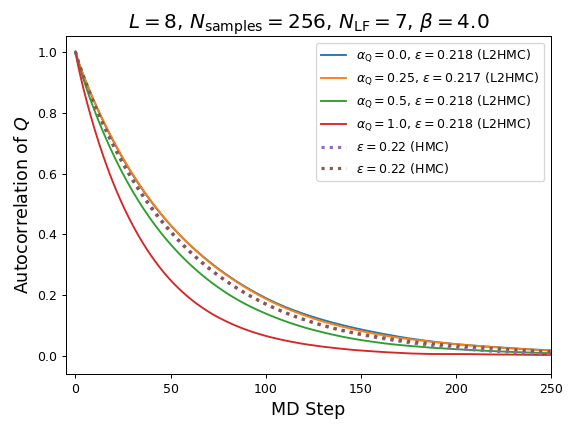

Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/charge_autocorr_plots/charge_autocorr_beta4.0.png
Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/charge_autocorr_plots/eps_plots/charge_autocorr_beta4.0.eps


<IPython.core.display.Javascript object>


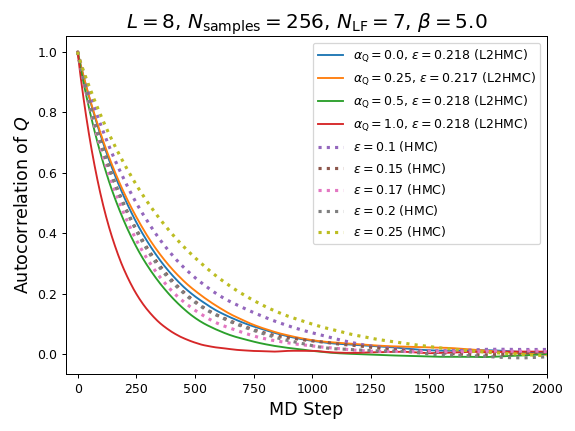

Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/charge_autocorr_plots/charge_autocorr_beta5.0.png
Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/charge_autocorr_plots/eps_plots/charge_autocorr_beta5.0.eps


<IPython.core.display.Javascript object>


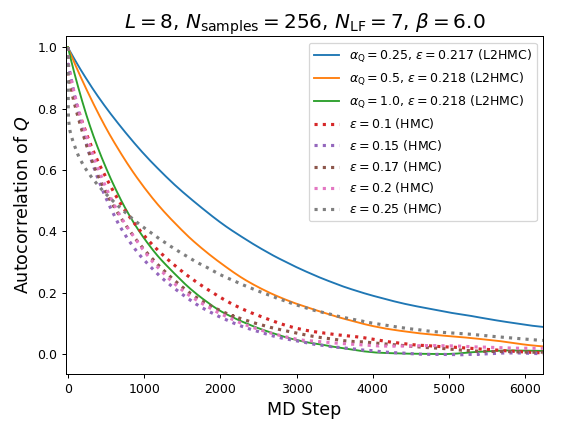

Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/charge_autocorr_plots/charge_autocorr_beta6.0.png
Saving figure to: ../../logs/charge_weight_test/cooley_logs/2019_5_2/leapfrog7/charge_autocorr_plots/eps_plots/charge_autocorr_beta6.0.eps


In [195]:
xlims_dict = {4.0: (-5, 250), 5.0: (-50, 2000), 6.0: (-50, 10000)}
l2hmc_data = (l2hmc_autocorrs, l2hmc_eps_dict)
hmc_data = (hmc_autocorrs_dict, hmc_eps_dict)
plot_autocorrs(l2hmc_data, hmc_data, xlims_dict)

In [ ]:

for beta in betas_unique:
    n = 0
    fig, ax = plt.subplots()
    for rt in rt_unique:
        for qw in qw_unique:
            for eps in eps_unique:
                key = (rt, lx_unique[0], ns_unique[0],
                       lf_unique[0], eps, beta, qw)
                if key in autocorrs.keys():
                    if rt == 'HMC':
                        ls = ':'
                        _qw = 'N/A'
                    else:
                        ls = '-'
                        _qw = qw
                    acorrs = np.array(autocorrs[key])
                    if len(acorrs.shape) > 2:
                        acorr = np.mean(np.mean(acorrs, axis=1), axis=0)
                    else:
                        acorr = np.mean(acorrs, axis=0)
                    label = ('{:<4}'.format(r'$\alpha_{\mathrm{Q}}=$') 
                             + f'{_qw:<3}, ' 
                             + '{:>4}'.format(r'$\varepsilon=$') 
                             + f'{float(eps):<.4g}, ' + f'{rt:>5}')
                    _ = ax.plot(acorr / np.max(acorr), label=label, ls=ls,
                                alpha = 1. - (n / 10.))
                    title = (f'{LX} x {LX}; ' 
                             + r'$N_{\mathrm{LF}} = $ ' + f'{LF}; '
                             + r'$\beta = $ ' + f'{beta}')
    #_ = ax.set_xticklabels = np.array([
    #    LF * np.array(ax.get_xticklabels(), dtype='float')
    #], dtype='str')
    n += 1
    _ = ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    _ = ax.set_xlabel('lag', fontsize=14)
    _ = ax.set_ylabel('Autocorrelation of ' + r'$Q$', fontsize=14)
    _ = ax.set_title(title, fontsize=16)
    _ = ax.legend(loc='best', fontsize=11)
    _ = ax.set_xlim((-50, 10050))
    #if float(beta) == 4.0:
    #    _ = ax.set_xlim((-10, 250))
    #if float(beta) == 6.0:
    #    _ = ax.set_xlim((-50, 1.5e4))
    #if float(beta) == 5.0:
    #    _ = ax.set_xlim((-50, 0.5e4))
    figs_dir = os.path.join(root_log_dir, 'autocorrelation_plots')
    eps_dir = os.path.join(figs_dir, 'eps_plots')
    io.check_else_make_dir(figs_dir)
    io.check_else_make_dir(eps_dir)
    out_file = os.path.join(
        figs_dir, f'top_charge_autocorr_vs_md_step_beta{beta}_zoomed.png'
    )
    out_file1 = os.path.join(
        eps_dir, f'top_charge_autocorr_vs_md_step_beta{beta}_zoomed.eps'
    )
    fig.tight_layout()
    #print(f'Saving figure to: {out_file}.')
    #plt.savefig(out_file, dpi=400, bbox_inches='tight')
    #print(f'Saving figure to: {out_file1}.')
    #plt.savefig(out_file1, dpi=400, bbox_inches='tight')

In [90]:
plaq_diffs = {}
plaq_stats = {}
for key, val in plaqs.items():
    charge_weight, beta = key
    plaq_exact = plaqs_exact[beta]
    diff = np.abs(val - plaq_exact)
    avg, err = get_mean_err(diff)
    plaq_diffs[key] = diff
    plaq_stats[beta] = {
        charge_weight: (avg, err)
    }

In [92]:
plaq_diffs.keys()

dict_keys([(0.25, 6.0), (0.25, 5.0), (0.25, 4.0), (0.0, 5.0), (0.0, 4.0), (1.0, 6.0), (1.0, 5.0), (1.0, 4.0), (0.5, 6.0), (0.5, 5.0), (0.5, 4.0)])

In [94]:
plaq_diffs[(0.25, 6.0)].shape

(20000, 256)

In [96]:
plaq_stats[4.0].keys()

dict_keys([0.5])

In [ ]:
plaq_stats[]